In [1]:
from Pipelines.process import *
import matplotlib.pyplot as plt
import seaborn as sns
from pygam import LinearGAM, GAM, s, f, te, l
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import re
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
import h2o
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch
import math
import numpy as np

In [2]:
df = process_raw('../test.csv').pipe(take_difference).pipe(take_population_rates).pipe(loose_correlated_vars).pipe(imputation_wave_1)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_251"; Java(TM) SE Runtime Environment (build 1.8.0_251-b08); Java HotSpot(TM) 64-Bit Server VM (build 25.251-b08, mixed mode)
  Starting server from /Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/6z/n_86gn216_56d0r44nq_pv3m0000gn/T/tmpj3dh0r4r
  JVM stdout: /var/folders/6z/n_86gn216_56d0r44nq_pv3m0000gn/T/tmpj3dh0r4r/h2o_azizbenmosbah_started_from_python.out
  JVM stderr: /var/folders/6z/n_86gn216_56d0r44nq_pv3m0000gn/T/tmpj3dh0r4r/h2o_azizbenmosbah_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/London
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.3
H2O_cluster_version_age:,19 days
H2O_cluster_name:,H2O_from_python_azizbenmosbah_5fkjih
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,177.8 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [KKR 03 (KK98 230)]
  warnings.warn(w)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [HIPASS J1247-77, Leo V Dwarf]
  warnings.warn(w)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [KKR 03 (KK98 230), UGCA 15 (DDO 6), UGCA 438 (ESO 407-018)]
  warnings.warn(w)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [KKR 03 (KK98 230), KUG 1210+301B (KK98 127)]
  warnings.warn(w)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [Andromeda Galaxy (M31), Andromeda XVII, KKR 03 (KK98 230), Leo V Dwarf, Maffei 2, NGC 247, NGC 4214 (UGC 7278), Pegasus III, UGCA 15 (DDO 6), UGCA 276 (DDO 113)]
  warnings.warn(w)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [Andromeda Galaxy (M31), KKR 03 (KK98 230)]
  warnings.warn(w)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [Andromeda Galaxy (M31), ESO 383-087 (ISG 39), ESO 540-030 (KDG 2), HIPASS J1247-77, Holmberg II (DDO 50, UGC 4305), IC 342, KKR 03 (KK98 230), NGC 4214 (UGC 7278), Pegasus III, Reticulum III, Sextans A (92205, DDO 75), Tucana II, UGC 8651 (DDO 181), UGCA 15 (DDO 6), UGCA 438 (ESO 407-018), UGCA 86]
  warnings.warn(w)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Grid Build progress: |███████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/azizbenmosbah/Desktop/prohack_dataset_avOqBYc/McHack/mck/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'galaxy' has levels not trained on: [Andromeda Galaxy (M31), ESO 383-087 (ISG 39), Eridanus II, IC 342, NGC 4214 (UGC 7278), UGCA 86]
  warnings.warn(w)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Grid Build progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


100% (50 of 50) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


H2O session _sid_9e51 closed.


In [8]:
df = pd.read_csv("../test.csv")

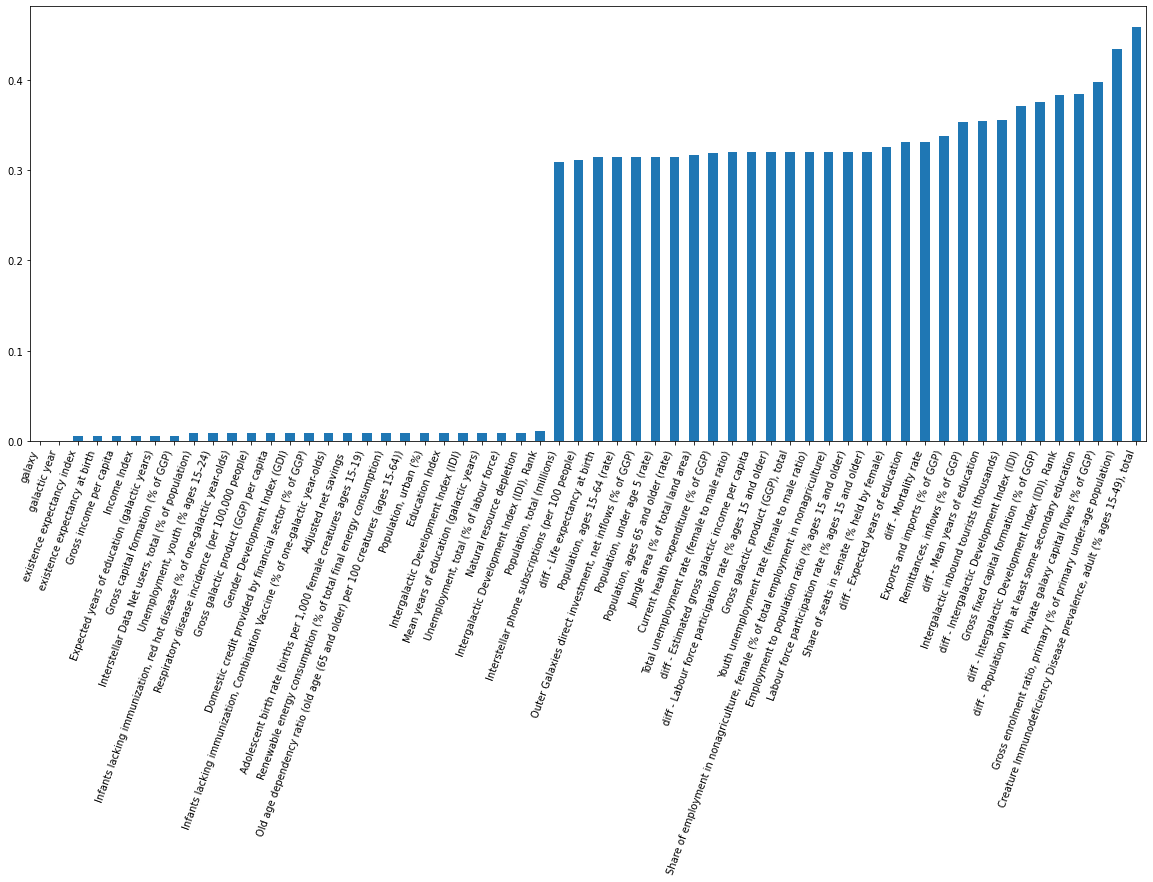

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
ser = (df.isnull().sum(axis=0) / len(df)).sort_values()
ax = ser.plot.bar(rot = 0)
plt.setp(ax.get_xticklabels(), rotation=70, horizontalalignment='right')
plt.show()

### We will compare the results of three models on the following 
1.	Population, urban (%)
2.	Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64))
3.	Adolescent birth rate (births per 1,000 female creatures ages 15-19)
4.	Infants lacking immunization, red hot disease (% of one-galactic year-olds)
5.	Infants lacking immunization, Combination Vaccine (% of one-galactic year-olds)
6.	Gross galactic product (GGP) per capita
7.	Natural resource depletion
8.	Renewable energy consumption (% of total final energy consumption
9.	Domestic credit provided by financial sector (% of GGP)
10.	Respiratory disease incidence (per 100,000 people)
11.	Interstellar Data Net users, total (% of population)
12.	Gender Development Index (GDI)
13.	Unemployment, total (% of labour force)
14.	Unemployment, youth (% ages 15–24)
15.	Adjusted net savings 
16.	Gross capital formation (% of GGP)
